# Calculation of NUDFT 

We proved an example for pre-trained supervised model [LSPIN](https://proceedings.mlr.press/v162/yang22i/yang22i.pdf) trained on PBMC dataset compared against deep classifier.

We provide the checkpoints in ckpts directory.


### Imports and util functions


In [1]:
import platform
from nfft import nfft_adjoint
import torch
import numpy as np
from matplotlib import pyplot as plt
from omegaconf import OmegaConf
import seaborn as sns
from lspin_pbmc import PBMC, Classifier, GatingNet

# which dimension use in the y_hat outputs (normalized with softmax)
TARGET_IDX = 1
COLUMNS_SUBSET=100000


def spectrum_NUDFT(x, y, kmax=50, nk=1000):
    kvals = np.linspace(0.1, kmax, nk+1)
    nufft = (1 / len(x)) * nfft_adjoint(-(x * kmax / nk), y, 2 * (nk + 1))[nk + 1:]
    return [kvals, np.array(nufft, dtype="complex_")]


def select_k_columns_with_max_variance(matrix):
    variance_per_column = torch.var(matrix, dim=0)
    _, sorted_indices = torch.sort(variance_per_column, descending=True)
    top_k_indices = sorted_indices[:COLUMNS_SUBSET]
    selected_columns = matrix[:, top_k_indices]
    return selected_columns

### Load pre-trained checkpoints

In [2]:
gated_cfg = OmegaConf.create(dict(
        gated=True,
        input_dim=17126,
        n_clusters=2,
        dataset="PBMC",
        data_dir="C:/data/fs/pbmc" if platform.system() == "Windows" else "." ,
        batch_size=256,
        repitions=5,
        sigma=0.5,
        reg_beta=100,
        devices=1,
        accelerator="gpu",
        max_epochs=100,
        deterministic=True,
        logger=True,
        log_every_n_steps=10,
        check_val_every_n_epoch=1,
        enable_checkpointing=False,
))

nongated_cfg = OmegaConf.create(dict(
    gated=False,
    input_dim=17126,
    n_clusters=2,
    dataset="PBMC",
    data_dir="C:/data/fs/pbmc" if platform.system() == "Windows" else "." ,
    batch_size=256,
    repitions=5,
    devices=1,
    accelerator="gpu",
    max_epochs=100,
    deterministic=True,
    logger=True,
    log_every_n_steps=10,
    check_val_every_n_epoch=1,
    enable_checkpointing=False,
))




The models were trained for ~400 epochs and we present the training/validation plots:

<img src="img/supervised_train_plots.png" alt="Alt text" width="500"/>
<img src="img/supervised_train_plots2.png" alt="Alt text" width="500"/>


In [8]:
gating_net = GatingNet(gated_cfg)
classifier_gated = Classifier(gated_cfg)
gating_net.load_state_dict(torch.load("ckpts/supervised/sparse_model_last_pbmc_beta_10_seed_0.pth")["gating"])
classifier_gated.load_state_dict(torch.load("ckpts/supervised/sparse_model_last_pbmc_beta_10_seed_0.pth")["clustering"])

# # load clustering model without gates:
classifier = Classifier(nongated_cfg)
classifier.load_state_dict(torch.load("ckpts/supervised/sparse_model_nogates_best_pbmc_seed_0.pth")["clustering"])

classifier = classifier.to('cpu')
classifier_gated = classifier_gated.to('cpu')

classifier.eval()
classifier_gated.eval()
gating_net.eval()

_, test_dataset = PBMC.setup(gated_cfg.data_dir)



Dataset PBMC stats:
X.shape:  (20742, 17126)
Y.shape:  (20742,)
X.min=-2.734075760955218, X.max=144.01736006468113
Y.min=0, Y.max=1
Label 0 has 10479 samples
Label 1 has 10263 samples
Split to train/test: train 16594 test 4148


<Figure size 640x480 with 0 Axes>

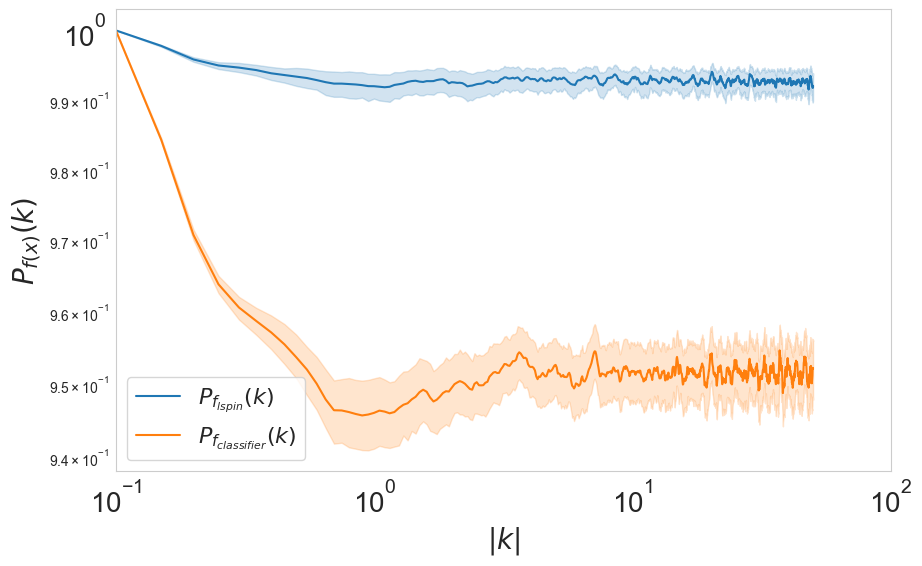

In [10]:
plt.clf()
plt.figure(figsize=(10, 6))
plt.yscale('log')  # Set the y-axis to logarithmic scale
plt.xscale('log')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlim((0.1, 100))
plt.xlabel('$|k|$', fontsize=20)
plt.ylabel('$P_{f(x)}(k)$', fontsize=20)
plt.grid(False)

with torch.no_grad():
    x_tensor = torch.tensor(test_dataset.data).float()
    filtered_dataset = select_k_columns_with_max_variance(x_tensor).cpu().numpy()
    normalized_dataset = filtered_dataset 
    gates = gating_net.get_gates(x_tensor)

    spectrum_nudft_all = []
    for feat_id in range(filtered_dataset.shape[-1]):
        spectrum_nudft_all.append(spectrum_NUDFT(filtered_dataset[:, feat_id], test_dataset.targets))
    spectra = [np.sqrt(np.abs(t[1] ** 2)).reshape(-1, 1) for t in spectrum_nudft_all]
    k = spectrum_nudft_all[0][0]
    k_repeated = np.concatenate([k] * len(spectra), axis=0).reshape(-1)

    # gated data, gated classifier predictions:
    e = classifier_gated.encoder(x_tensor * gates)
    y_hat = torch.softmax(classifier_gated.head(e), dim=1)[:, TARGET_IDX].numpy()
    classifier_gated_spectrum_nudft_all = []
    non_zero_ids = torch.nonzero(gates.sum(dim=0) > 0, as_tuple=True)[0].long()
    max_spectrum_val = - np.inf
    max_spectrum_gated_val = - np.inf

    # raw data, classifier predictions:
    e_raw = classifier.encoder(x_tensor)
    y_hat_raw = torch.softmax(classifier.head(e_raw), dim=1)[:, TARGET_IDX].numpy()
    classifier_spectrum_nudft_all = []
    normalized_gated_dataset = normalized_dataset * gates.numpy()
    for feat_id in range(normalized_dataset.shape[-1]):
        feat_spectrum = spectrum_NUDFT(normalized_gated_dataset[:, feat_id], y_hat)
        max_spectrum_gated_val = max(max_spectrum_gated_val, np.abs(feat_spectrum[1]).max())
        classifier_gated_spectrum_nudft_all.append(feat_spectrum)

        feat_spectrum_raw = spectrum_NUDFT(normalized_dataset[:, feat_id], y_hat_raw)
        max_spectrum_val = max(max_spectrum_val, np.abs(feat_spectrum_raw[1]).max())
        classifier_spectrum_nudft_all.append(feat_spectrum_raw)

    classifier_gated_spectra = [np.abs(t[1]).reshape(-1) for t in classifier_gated_spectrum_nudft_all]
    classifier_gated_spectra_single_column = np.concatenate(classifier_gated_spectra, axis=0)
    classifier_gated_spectra_single_column = classifier_gated_spectra_single_column / max_spectrum_gated_val
    sns.lineplot(x=k_repeated, y=classifier_gated_spectra_single_column, label='$P_{f_{lspin}}(k)$')

    classifier_model_spectra = [np.abs(t[1]).reshape(-1) for t in classifier_spectrum_nudft_all]
    classifier_spectra_single_column = np.concatenate(classifier_model_spectra, axis=0)
    classifier_spectra_single_column = classifier_spectra_single_column / max_spectrum_val
    sns.lineplot(x=k_repeated, y=classifier_spectra_single_column, label='$P_{f_{classifier}}(k)$')

plt.legend(fontsize=16)
plt.show()

As it could be seen from the plot, the gating of the features adds a high frequency bias and makes the predictor to be more appropriate for tabular dataset. Please refer to the paper [An Inductive Bias for Tabular Deep Learning](https://proceedings.neurips.cc/paper_files/paper/2023/file/8671b6dffc08b4fcf5b8ce26799b2bef-Paper-Conference.pdf) and Figure 1:


<img src="img/freq_bias.png" alt="Alt text" width="500"/>

Due to their heterogeneous nature, tabular datasets tend to describe higher frequency target functions compared to images. The spectra corresponding to image datasets (curves in color) tend to feature lower Fourier amplitudes at higher frequencies than hetergoneous tabular datasets (cyan region).
